### An example of how to run the finetuned model on new data

Download the finetuned model checkpoint `checkpoint-finetuned.zip` from [here](https://zenodo.org/records/13677353) and extract the checkpoint files.

Prepare your data as a numpy array. The model will accept a batch of images of shape (N, 224, 224, 1), where N is the number of images in the batch, and the images are clipped and arcsinh stretched. Below, my images are in a HDF5 file, but you can update this as necessary for different data.

In [9]:
import h5py
import numpy as np
import skimage

In [10]:
cutouts = h5py.File('example_data.hdf')
images = []

for key in cutouts.keys():
    cutout = np.array(cutouts[key]['DATA'])
    mask = np.array(cutouts[key]['MASK']).astype(int) & (1 | (1 << 8) | (1 << 9))

    # Resize to (224, 224)
    mask = skimage.transform.resize(mask, (224,224))
    img = skimage.transform.resize(cutout, (224,224))

    # Scale the images and apply the mask
    img = np.clip(img, a_min=0, a_max=10)
    img = np.arcsinh(img / 0.017359) 
    img = img * ~(mask > 0)

    # Place into array
    img = np.expand_dims(img, -1) # Reshape the array to (224, 224, 1)
    images.append(img)

data = np.array(images) 

Create the model and load the finetuned weights. By default this function will look for the checkpoint data in the `./checkpoints/` folder. We load the validation version of the model, which does not include any random augmentations. Predictions should not change qualitatively with the other version, but this way they will be identical each time.

In [11]:
import sys
sys.path.append('..') # Hacky way to be able to import files from parent directory

from model import load_val_model

In [12]:
model = load_val_model(model_name='checkpoint-finetuned', model_path_prefix='../checkpoints/')

Run the model on the images, which gives an array of Tensorflow Probability distributions.

In [13]:
outputs = model(data)

2024-09-27 10:54:21.319866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [4]
	 [[{{node shape}}]]
2024-09-27 10:54:21.320911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [4]
	 [[{{node shape}}]]
2024-09-27 10:54:21.352194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [4]
	 [[{{node shape}}]]
2024-09-27 10:54:21.352355: I tens

In [14]:
print(outputs)

tfp.distributions._TensorCoercible("tensor_coercible", batch_shape=[5], event_shape=[1], dtype=float32)


To get the actual model predictions, we find the peak of the probability distirbution, and also use the CDFs to get uncertainties on the predictions.

In [15]:
x = np.linspace(0, 1, 1000) # Need to define where we evaluate all the distributions
dists = outputs.distribution.prob(x) # Get all the output probability distributions as arrays
predictions = x[np.argmax(dists, axis=1)] # Find the peaks of the distributions
cdfs = outputs.distribution.cdf(x) # Get the CDFs

# Get the 15 and 85 percentile uncertainties
q15s = np.argmax(cdfs >= 0.15, axis=1)
q85s = np.argmax(cdfs >= 0.85, axis=1)
lower_errors = np.abs(predictions - x[q15s])
upper_errors = np.abs(x[q85s] - predictions)

print(f'Mean prediction is {np.mean(predictions)}')

Mean prediction is 0.057257257257257256


We can look at one of the output distributions as an example.

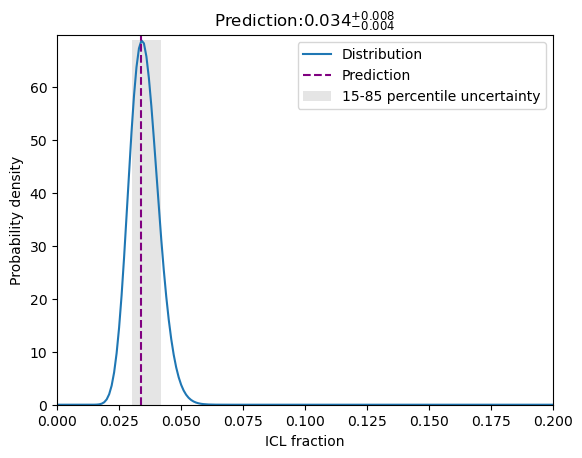

In [16]:
import matplotlib.pyplot as plt

# Display one of the output distributions
example_dist = dists[0]
prediction = predictions[0]
q15 = q15s[0]
q85 = q85s[0]

plt.plot(x, example_dist)
plt.axvline(prediction, c='purple', linestyle='--')
plt.fill_between([x[q15], x[q85]], min(example_dist), max(example_dist), facecolor='gray', alpha=0.2)
plt.xlim(0, 0.2)
plt.ylim(0, max(example_dist) + 1)
plt.xlabel('ICL fraction')
plt.ylabel('Probability density')
plt.legend(['Distribution', 'Prediction', '15-85 percentile uncertainty'])
plt.title('Prediction:'+str(round(prediction,3))+'$^{+'+str(round(upper_errors[0], 3))+'}_{-'+str(round(lower_errors[0],3))+'}$')
plt.show()